In [55]:
import os
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

from transformers import ViTImageProcessor, ViTForImageClassification

import matplotlib.pyplot as plt

%matplotlib inline

### Data Pre-processing and visualization

In [65]:
# Load dataset using DataLoader
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # mean and std calculated below
    # transforms.Normalize(
    #     mean=[0.4547, 0.4337, 0.4011],
    #     std=[0.2266, 0.2237, 0.2316]
    # )
])

dataset = ImageFolder(root='Places2_simp', transform=transform)
class_names = dataset.classes
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [66]:
print("Number of classes:", len(os.listdir('Places2_simp')))

Number of classes: 40


In [76]:
# Image size
images[0].shape
# [color_channels, length, height]

torch.Size([3, 224, 224])

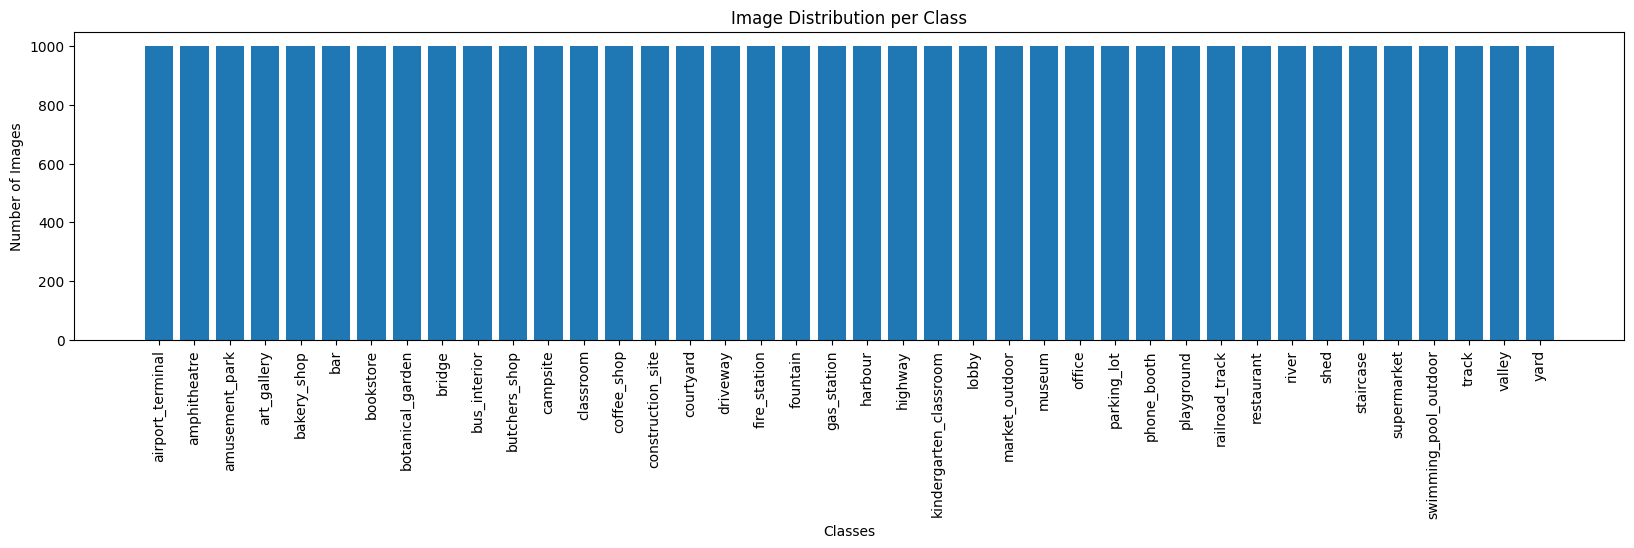

In [73]:
# Images per class or Class distribution Plot
labels = [label for _, label in dataset.samples]
class_counts = Counter(labels)
idx_to_class = {v: k for k, v in dataset.class_to_idx.items()}

plt.figure(figsize=(20,4))
plt.bar([idx_to_class[i] for i in class_counts.keys()], class_counts.values())
plt.xticks(rotation=90)
plt.ylabel("Number of Images")
plt.xlabel("Classes")
plt.title('Image Distribution per Class')
plt.show()

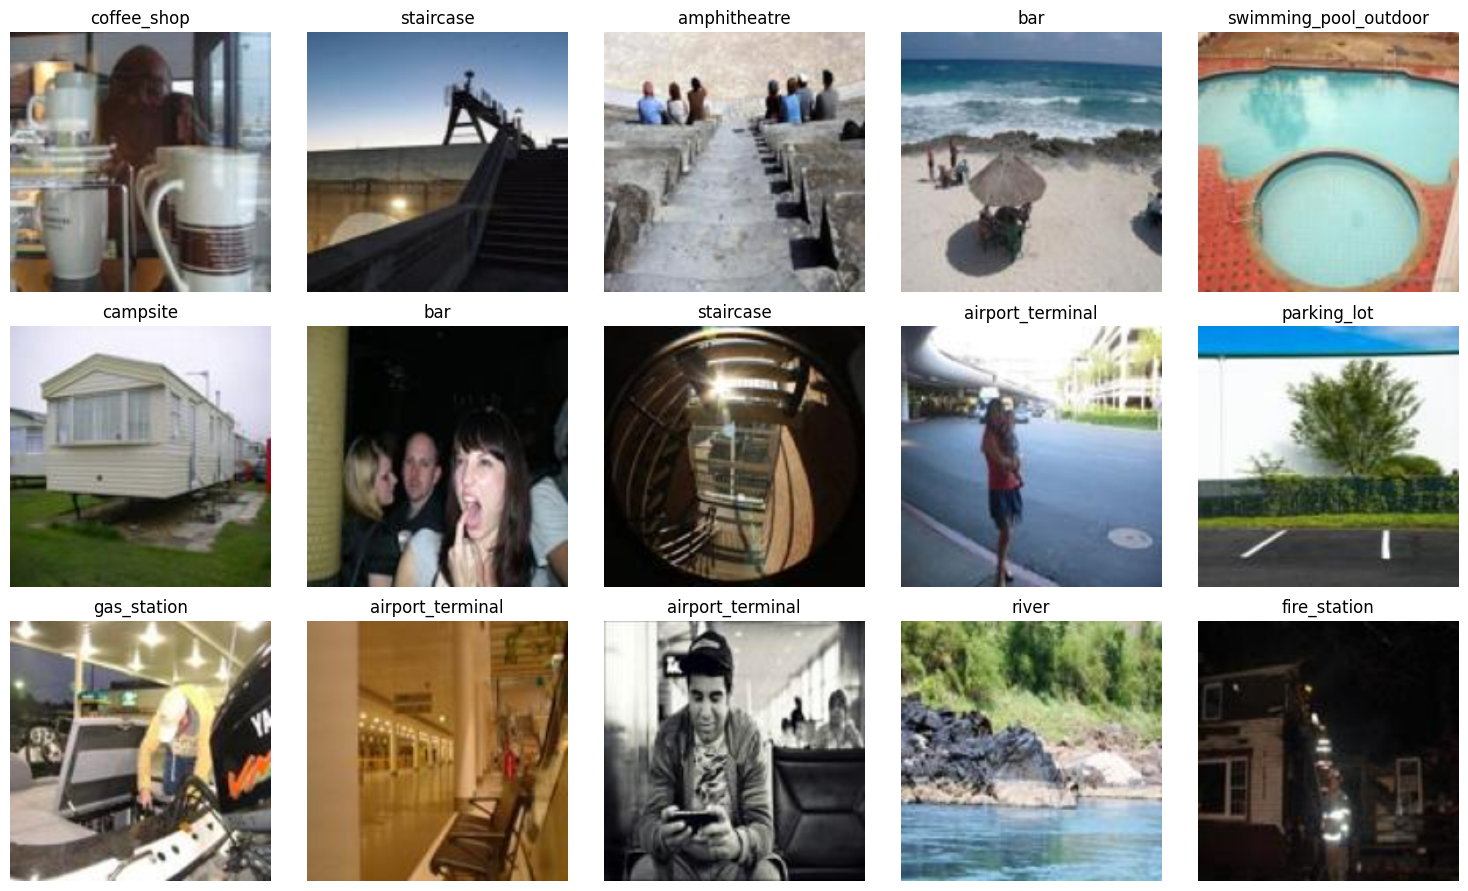

In [68]:
# Plot random images from dataset
def plot_random_images(images, labels):
    num_images = 15
    cols = 5
    rows = 3
    
    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        img = images[i].numpy().transpose((1, 2, 0))
        plt.imshow(img)
        plt.title(class_names[labels[i]])
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()
    
# Get a batch of data
images, labels = next(iter(dataloader))
plot_random_images(images, labels)

In [69]:
# Compute mean and std, useful for normalizing
means = []
stds = []

for img, _ in tqdm(dataset, desc="Computing mean/std"):
    means.append(torch.mean(img, dim=(1,2)))  # mean per channel
    stds.append(torch.std(img, dim=(1,2)))    # std per channel

means = torch.stack(means).mean(0)
stds = torch.stack(stds).mean(0)

print(f"Mean per channel(R, G, B): {means}")
print(f"Std per channel(R, G, B): {stds}")

Computing mean/std: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 40000/40000 [00:39<00:00, 1020.30it/s]

Mean per channel: tensor([0.4547, 0.4337, 0.4011])
Std per channel: tensor([0.2266, 0.2237, 0.2316])


### Setup pre-trained transformer model for training

In [50]:
# Load pre-trained model
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [51]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [52]:
# Disable training for existing pre-trained layers
for p in model.parameters():
  p.requires_grad = False

In [53]:
# Update the classier layer for scene recognition task
model.classifier = nn.Linear(768, 40)

In [54]:
lr = 3e-4
optimizer = torch.optim.AdamW(model.classifier.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

# --- 3. Device Setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"Using device: {device}")
print("Training only the final classifier layer.")

# --- 4. Training Loop (Simplified with Placeholder Data) ---
num_epochs = 3 # Set a small number of epochs for demo

print(f"\n--- Starting Minimal Training Loop ---")

for epoch in range(num_epochs):
    model.train() # Set model to training mode
    epoch_loss = 0.0

    print(f"Epoch {epoch + 1}/{num_epochs}")

    # ** IMPORTANT: This loop uses FAKE placeholder data **
    # In your real code, this loop iterates over your DataLoader:
    # for batch in train_loader:
    #     inputs = batch['pixel_values'].to(device)
    #     labels = batch['labels'].to(device)
    #     ... (rest of the loop)
    pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{num_epochs} [Train]", leave=True)
    for x, y in pbar:
        # --- Simulate a batch of data ---
        # Replace this with actual data loading
        inputs = x.to(device) # (B, C, H, W)
        labels = y.to(device) # (B)
        # --- End Simulation ---

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(pixel_values=inputs) # Pass input with correct kwarg name
        logits = outputs.logits

        # Calculate loss
        loss = criterion(logits, labels)

        # Backward pass (calculate gradients)
        loss.backward()

        # Update weights
        optimizer.step()

        epoch_loss += loss.item()
        pbar.set_postfix({'loss': loss.item()})
    avg_loss = epoch_loss / batches_per_epoch
    print(f"--- Epoch {epoch + 1} Average Loss: {avg_loss:.4f} ---")

print("\nMinimal training loop finished.")


Using device: cpu
Training only the final classifier layer.

--- Starting Minimal Training Loop ---
Epoch 1/3


Epoch 1/3 [Train]:   2%|██▏                                                                                                | 14/625 [01:57<1:25:22,  8.38s/it, loss=3.45]


KeyboardInterrupt: 